<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neuronal_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# snnTorch - Neuronal Dynamics with ``snntorch``
## Tutorial 2
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will:
* Learn the fundamentals of the leaky integrate-and-fire (LIF) neuron model
* Use snnTorch to implement variations of the LIF model: 
  * Lapicque's neuron model
  * Stein's neuron model
  * 0$^{th}$ Order Spike Response Model
<!-- * Plot the output behavior of the neurons -->
<!-- * Interpret the computational graph of a spiking neuron -->
<!-- * Automatically initialize the hidden states of the neurons [keep in tute, but delete explanation]? -->
* Implement a feedforward spiking neural network

>Part of this tutorial was inspired by the book [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [273]:
!pip install snntorch

# 1. The Spectrum of Neuron Models
A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the extremely simple artificial neuron that pervades all facets of modern deep learning.

**Hodgkin-Huxley Neuron Models**$-$While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use. We expect this to change as more rigorous theories of how neurons contribute to higher-order behaviors in the brain are uncovered.

**Artificial Neuron Model**$-$On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights and passed through an activation function. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks.

**Leaky Integrate-and-Fire Neuron Models**$-$Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike. The LIF neuron abstracts away the shape and profile of the output spike; it is simply treated as a discrete event. As a result, information is not stored within the spike, but rather the timing (or frequency) of spikes. Simple spiking neuron models have produced much insight into the neural code, memory, network dynamics, and more recently, deep learning. The LIF neuron sits in the sweet spot between biological plausibility and practicality. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>

<!-- Researchers might spend their entire lives dedicated to developing neuron models. Some of these models are straightforward extensions of the HH and LIF models, while other models find completely different applications, such as in neuropharmocology. -->

The different versions of the LIF model each have their own dynamics and use-cases. snnTorch currently supports three types of LIF neurons:
* Lapicque's RC model: ``snntorch.Lapicque``
* Stein's neuron model: ``snntorch.Stein``
* 0$^{th}$ Order Spike Response Model: ``snntorch.SRM0``

Before learning how to use them, let's understand how to construct a simple LIF neuron model.

<!-- In general, the most obvious difference is that the SRM0 model incorporates a delay between the input and output. When an input spike arrives at an SRM0 neuron, the membrane potential will increase over a finite time. If an output spike were to be triggered, it would experience a delay with respect to the input. On the other hand, Stein's model allows for an instantaneous rise of membrane potential. We'll dig into where these might be useful shortly. -->


# 2. The Leaky Integrate-and-Fire Neuron Model

## 2.1 Spiking Neurons: Intuition

A neuron might be connected to 1,000 $-$ 10,000 other neurons. If one neuron spikes, all of these downhill neurons will feel it. But what determines whether a neuron spikes in the first place? The past century of experiments demonstrate that if a neuron experiences *sufficient* stimulus at its input, then we might expect it to become excited and fire its own spike. 

Where does this stimulus come from? It could be from
* the sensory periphery, 
* an invasive electrode artificially stimulating the neuron, or in most cases,
* from other pre-synaptic neurons. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>


Given that these spikes are very short bursts of electrical activity, it is quite unlikely for all input spikes to arrive at the neuron body in precise unison. This indicates the presence of temporal dynamics that 'sustain' the input spikes, kind of like a delay.


## 2.2 The Passive Membrane

Like all cells, a neuron is surrounded by a thin membrane. This membrane is a lipid bilayer that insulates the conductive saline solution within the neuron from the extracellular medium. Electrically, the two conductors separated by an insulator is a capacitor. 

Another function of this membrane is to control what goes in and out of this cell (e.g., ions such as Na$^+$). The membrane is usually impermeable to ions which blocks them from entering and exiting the neuron body. But there are specific channels in the membrane that are triggered to open by injecting current into the neuron. This charge movement is electrically modelled by a resistor.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>


Now say some arbitrary time-varying current $I_{\rm in}(t)$ is injected into the neuron, be it via electrical stimulation or from other neurons. The total current in the circuit is conserved, so:

$$I_{\rm in}(t) = I_{R} + I_{C}$$

From Ohm's Law, the membrane potential measured between the inside and outside of the neuron $U_{\rm mem}$ is proportional to the current through the resistor:

$$I_{R}(t) = \frac{U_{\rm mem}(t)}{R}$$

The capacitance is a proportionality constant between the charge stored on the capacitor $Q$ and $U_{\rm mem}(t)$:


$$Q = CU_{\rm mem}(t)$$

The rate of change of charge gives the capacitive current:

$$\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}$$

Therefore:

$$I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}$$

$$\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The right hand side of the equation is of units **\[Voltage]**. On the left hand side of the equation, the term $\frac{dU_{\rm mem}(t)}{dt}$ is of units **\[Voltage/Time]**. To equate it to the left hand side (i.e., voltage), $RC$ must be of unit **\[Time]**. We refer to $\tau = RC$ as the time constant of the circuit:

$$ \tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The passive membrane is therefore described by a linear differential equation.

For a derivative of a function to be of the same form as the original function, i.e., $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$, this implies the solution is exponential with a time constant $\tau$.

Say the neuron starts at some value $U_{0}$ with no further input, i.e., $I_{\rm in}(t)=0$. The solution of the linear differential equation is:

$$U_{\rm mem}(t) = U_0e^{-\frac{t}{\tau}}$$

The general solution is shown below.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

## 2.3 Lapicque's LIF Neuron Model

This similarity between nerve membranes and RC circuits was observed by [Louis Lapicque in 1907](https://core.ac.uk/download/pdf/21172797.pdf). He stimulated the nerve fiber of a frog with a brief electrical pulse, and found that membranes could be approximated as a capacitor with a leakage. We pay homage to his findings by naming the basic LIF neuron model in snnTorch after him. 

Most of the concepts in Lapicque's model carry forward to other LIF neuron models. Now let's simulate this neuron using snnTorch.

### 2.3.1 Lapicque: Without Stimulus

First, import the packages needed to run Lapicque's neuron model: snnTorch and PyTorch.

In [274]:
import snntorch as snn
import torch

The membrane potential has a time constant $\tau = RC$ associated with it. This can be equivalently represented by a decay rate $\beta$ that specifies the ratio of potential between subsequent time steps:

$$\beta = \frac{U_0e^{-\frac{1}{\tau}}}{U_0e^{-\frac{0}{\tau}}} = \frac{U_0e^{-\frac{2}{\tau}}}{U_0e^{-\frac{1}{\tau}}} = \frac{U_0e^{-\frac{3}{\tau}}}{U_0e^{-\frac{2}{\tau}}}=~~...$$
$$\implies \beta = e^{-\frac{1}{\tau}}$$

Setting $\tau = 5\times 10^{-3} \implies \beta \approx 0.819$:

In [275]:
# RC time constant
tau_mem = 5e-3
time_step = 1e-3 # one time step = 1ms

# decay p/time step
beta = float(torch.exp(torch.tensor(-time_step/tau_mem)))

# Number of time steps to simulate
num_steps = 200

print(f"Membrane decay rate ('beta'): {beta}")

Membrane decay rate ('beta'): 0.8187307715415955


Instantiating Lapicque's neuron only requires the following line of code:

In [276]:
# leaky integrate and fire neuron
lif1 = snn.Lapicque(beta=beta)

The same thing can also be accomplished by specifying the parallel RC values:

In [277]:
R = 5
C = 1e-3

lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

print(f"Membrane decay rate ('beta'): {lif1.beta[0]}")

Membrane decay rate ('beta'): 0.8187307715415955


To use this neuron: 

**Inputs**
* `spk_in`: each element of $I_{\rm in}$, which are all `0` for now, is sequentially passed as an input
* `mem`: the membrane potential at the present time $t$ is also passed as input. Initialize it arbitrarily as $U_0 = 0.9~V$.

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t+1]$ at the next time step ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U_{\rm mem}[t+1]$ at the next time step

These all need to be of type `torch.Tensor`.


In [278]:
# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # membrane potential of 0.9 at t=0
cur_in = torch.zeros(num_steps)  # input is 0 for all t 
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

These values are only for the initial time step $t=0$. We'd like to watch the evolution of `mem` over time. The list `mem_rec` is initialized to record these values at every time step.

In [279]:
# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

Now it's time to run a simulation! 200 time steps will be simulated, updating `mem` at each step and recording its value in `mem_rec`:

In [280]:
# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

Let's take a look at how the membrane potential and synaptic current evolved.

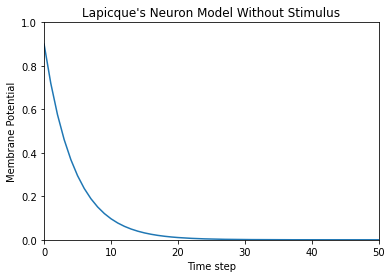

In [281]:
import matplotlib.pyplot as plt

plt.title("Lapicque's Neuron Model Without Stimulus")
plt.plot(mem_rec, label="Membrane Potential")
plt.xlabel("Time step")
plt.ylabel("Membrane Potential")
plt.xlim([0, 50])
plt.ylim([0, 1])
plt.show()

This matches the dynamics that were previously derived. We've proven to ourselves that the membrane potential will decay over time in the absence of any input stimuli. 

### 2.3.2 Lapicque: Step Input

Now let's apply a step current $I_{\rm in}(t)$ that switches on at $t=t_0$. Given the linear first-order differential equation:

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t),$$

the general solution will be:

$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

If the membrane potential is initialized to $U_{\rm mem}(t=0) = 0 V$, then:

$$U_{\rm mem}(t)=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

Let's visualize what this looks like by triggering a current pulse of $I_{in}=100mA$ at $t_0 = 10ms$.

In [282]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.1), 0)  # input current turns on at t=10

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

As before, 200 time steps will be simulated. But this time, the new values of `cur_in` will be passed:

In [283]:
# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

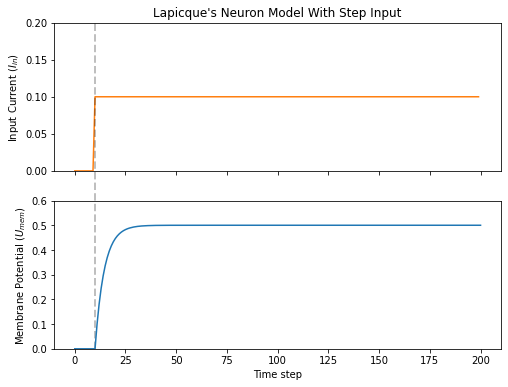

In [284]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.2])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Step Input")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 0.6])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

The membrane potential exponentially rises and then stabilizes at $U_{\rm mem}=I_{\rm in}R$:

In [285]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: 0.5 V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


Close enough!

### 2.3.3 Lapicque: Pulse Input

Now what if the step input was clipped at $t=30ms$?

In [286]:
# Initialize input current pulse.
cur_in1 = torch.cat((torch.zeros(10), torch.ones(20)*(0.1), torch.zeros(170)), 0)  # input turns on at t=10, off at t=30

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec1 = [mem]

In [287]:
# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)

  # Store recordings of membrane potential
  mem_rec1.append(mem)

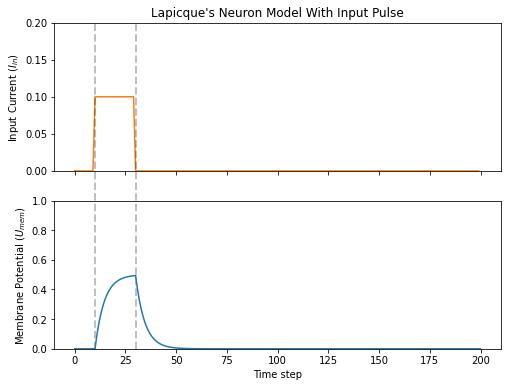

In [288]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in1, c="tab:orange")
ax[0].set_ylim([0, 0.2])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse")

# Plot membrane potential
ax[1].plot(mem_rec1)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=30, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

It appears to rise just as it did for the step input, but now it decays with a time constant of $\tau$ as in our first simulation. 

Let's deliver approximately the same amount of charge $Q = I \times t$ to the circuit in half the time. This means our input current amplitude will need to be increased by a little, and the time window will be decreased.

In [289]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec2 = [mem]

In [290]:
# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)

  # Store recordings of membrane potential
  mem_rec2.append(mem)

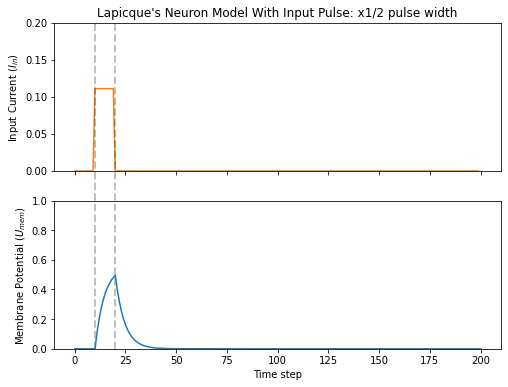

In [291]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in2, c="tab:orange")
ax[0].set_ylim([0, 0.2])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse: x1/2 pulse width")

# Plot membrane potential
ax[1].plot(mem_rec2)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=20, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

plt.xlabel("Time step")

plt.show()

Let's do that again, but with an even faster input pulse and higher amplitude:

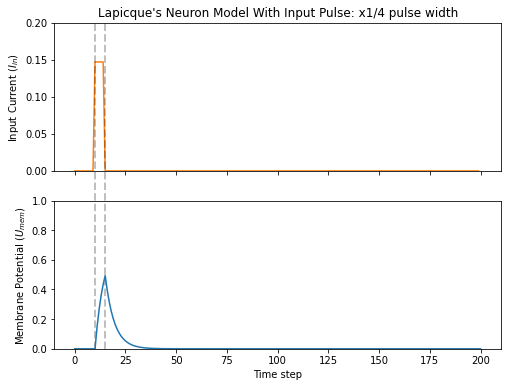

In [292]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec3 = [mem]

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)

  # Store recordings of membrane potential
  mem_rec3.append(mem)

# Generate Plots
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in3, c="tab:orange")
ax[0].set_ylim([0, 0.2])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse: x1/4 pulse width")

# Plot membrane potential
ax[1].plot(mem_rec3)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=15, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

Let's compare all three experiments on the same plot:

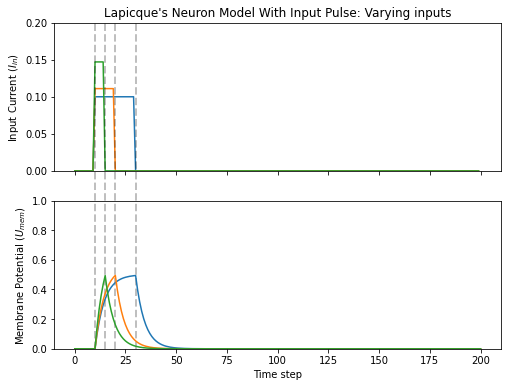

In [293]:
# Generate Plots
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in1)
ax[0].plot(cur_in2)
ax[0].plot(cur_in3)
ax[0].set_ylim([0, 0.2])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse: Varying inputs")

# Plot membrane potential
ax[1].plot(mem_rec1)
ax[1].plot(mem_rec2)
ax[1].plot(mem_rec3)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=15, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=20, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=30, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

plt.xlabel("Time step")

plt.show()

As the input current pulse amplitude increases, the rise time of the membrane potential speeds up. In the limit of the input current pulse width becoming infinitesimally small, $T_W \rightarrow 0s$, the membrane potential rise time will jump straight up:

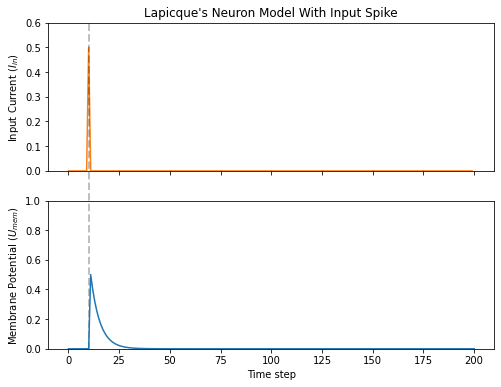

In [294]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10), torch.ones(1)*0.5, torch.zeros(189)), 0)  # input only on for 1 time step

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec4 = [mem]

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)

  # Store recordings of membrane potential
  mem_rec4.append(mem)

# Generate Plots
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in4, c="tab:orange")
ax[0].set_ylim([0, 0.6])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Spike")

# Plot membrane potential
ax[1].plot(mem_rec4)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

The current pulse width is now so short, it effectively looks like a spike. That is to say, charge is delivered in an infinitely short period of time, $I_{\rm in}(t) = Q/t_0$ where $t_0 \rightarrow 0$. More formally:

$$I_{\rm in}(t) = Q \delta (t-t_0),$$

where $\delta (t-t_0)$ is the Dirac-Delta function. Physically, it is impossible to 'instantaneously' deposit charge. But integrating $I_{\rm in}$ gives a result that makes physical sense, as we can obtain the charge delivered:

$$1 = \int^{t_0 + a}_{t_0 - a}\delta(t-t_0)dt$$

$$f(t_0) = \int^{t_0 + a}_{t_0 - a}f(t)\delta(t-t_0)dt$$

Here, $f(t_0) = I_{\rm in}(t_0=10) = 0.5A \implies f(t) = Q = 0.5C$.


### 2.3.4 Lapicque: Firing

So far, we have only seen how a neuron will react to spikes at the input. For a neuron to generate and emit its own spikes at the output, we need to combine the passive membrane model with a threshold.

If the membrane potential exceeds this threshold, then a voltage spike will be generated, external to the passive membrane model. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>

By default, `threshold=1` for all neuron models in snnTorch. So applying a step current input that is insufficient will result in the neuron to function only in the subthreshold regime. This time, we will create a list called `spk_rec` to record any output spikes if they occur. The current step will be set to $I_{\rm in} = 0.15 A$. 

In [295]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.15), 0)

# Initialize membrane and output
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

In [296]:
# Create a new neuron with a slow time constant
lif2 = snn.Lapicque(R=5, C=10)

print(f"Membrane decay rate ('beta'): {lif2.beta[0]}")

Membrane decay rate ('beta'): 0.9801986813545227


Note how this new value of $\beta$ is much larger than `lif1.beta`$\approx 0.82$. 

For `lif2.beta`$=0.98$, the membrane potential is 98% of the value of that of the previous time step, and therefore a much slower decay rate.

In [297]:
# Simulation run across 200 time steps. 
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)

  # record outputs over time
  mem_rec.append(mem)
  spk_rec.append(spk_out)

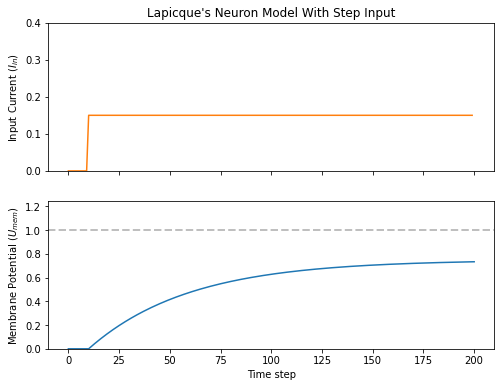

In [298]:
# Generate Plots
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.4])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Step Input")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1.25])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=1.0, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

plt.xlabel("Time step")

plt.show()

The membrane potential fails to reach the threshold of 1.0. Instead, it reaches the steady-state value of $I_{\rm in}R = 0.15A \times 5Ω = 0.75V$:

In [299]:
print(f"The calculated steady state membrane potential is: {lif1.R*cur_in[199]}")
print(f"The simulated steady state membrane potential is: {mem_rec[199][0]}")

The calculated steady state membrane potential is: 0.75
The simulated steady state membrane potential is: 0.733526349067688


> Note: these are non-biologically accurate values, and are chosen for simplicity.

To reach the threshold, we need to ensure that $I_{\rm in}R > U_{\rm thr}$. So set $I_{\rm in} = 0.21 A$:

In [300]:
# Larger current step
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.21), 0)

# Initialize membrane and output
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

In [301]:
# Simulation run across 200 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)

  # record outputs over time
  mem_rec.append(mem)
  spk_rec.append(spk_out)

To plot our results, let's import `snntorch.spikeplot`. From Tutorial 1, we learnt how to use it to create raster plots of spike responses.

In [302]:
from snntorch import spikeplot as splt

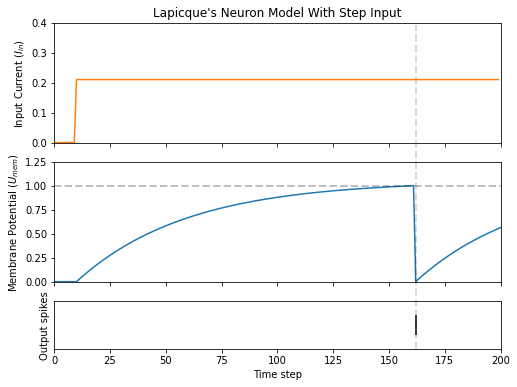

In [303]:
# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [1, 1, 0.4]})

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.4])
ax[0].set_xlim([0, 200])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Step Input")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1.25])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=1.0, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(torch.tensor(spk_rec), ax[2], s=400, c="black", marker="|")
ax[2].axvline(x=162, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.ylabel("Output spikes")
plt.yticks([]) 

plt.show()

The membrane potential exponentially rises and then hits the threshold, at which point it resets. We can roughly see this occurs between $155s < t_{\rm spk} < 165s$:

In [304]:
print(spk_rec[155:165])

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([1.]), tensor([0.]), tensor([0.])]


The absence of a spike is represented by $S_{\rm out}=0$, and the occurrence of a spike is $S_{\rm out}=1$. Here, the spike occurs at $S_{\rm out}(t=162)=1$.

If you are wondering why each of these entries is stored as a tensor, it is because soon we will simulate large scale neural networks. Each entry will contain the spike responses of many neurons.

If $I_{\rm in}$ is increased, then the membrane potential approaches $U_{\rm thr}$ faster:

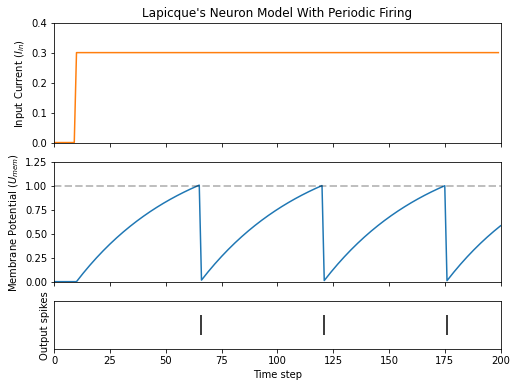

In [305]:
# Even Larger current step
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)

# Initialize membrane and output
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 200 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)

  # record outputs over time
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [1, 1, 0.4]})

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.4])
ax[0].set_xlim([0, 200])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Periodic Firing")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1.25])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=1.0, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(torch.tensor(spk_rec), ax[2], s=400, c="black", marker="|")
plt.ylabel("Output spikes")
plt.yticks([]) 

plt.show()

A similar increase in firing frequency can also be induced by decreasing the threshold. This requires initializing a new neuron model, but the rest of the code block is the exact same as above:

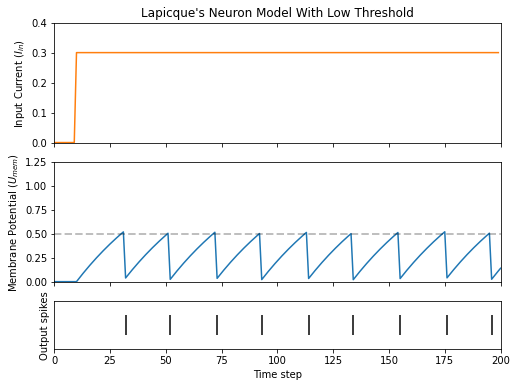

In [306]:
# Half the threshold
lif3 = snn.Lapicque(R=5, C=10, threshold=0.5)

# Initialize membrane and output
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 200 time steps.
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)

  # record outputs over time
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [1, 1, 0.4]})

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.4])
ax[0].set_xlim([0, 200])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Low Threshold")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1.25])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(torch.tensor(spk_rec), ax[2], s=400, c="black", marker="|")
plt.ylabel("Output spikes")
plt.yticks([]) 

plt.show()

That's what happens for a constant current injection. But in both deep neural networks and in the biological brain, most neurons will be connected to other neurons. Therefore, they are more likely to receive spikes rather than a constant current injections. 

### 2.3.4 Lapicque: Spike Inputs

Let's use some of the skills we learnt in [Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb), and use the `snntorch.spikegen` module to create some randomly generated input spikes.

In [307]:
from snntorch import spikegen 

# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)

Run the following code block to see how many spikes have been generated.

There are 78 total spikes out of 200 time steps.


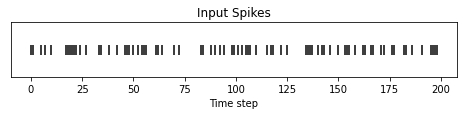

In [308]:
# Tell me the number of spikes
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

# Now show me the spikes
from snntorch import spikeplot as splt

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")

plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

In [309]:
# Refresh all our hidden and output variables
mem = torch.ones(1)*0.5  # membrane potential of 0.5 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

# Create a trace of the variables of interest
mem_rec = [mem]
spk_rec = [spk_out]

# Run the simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)

  # Store recordings of output and hidden states
  spk_rec.append(spk_out)
  mem_rec.append(mem)

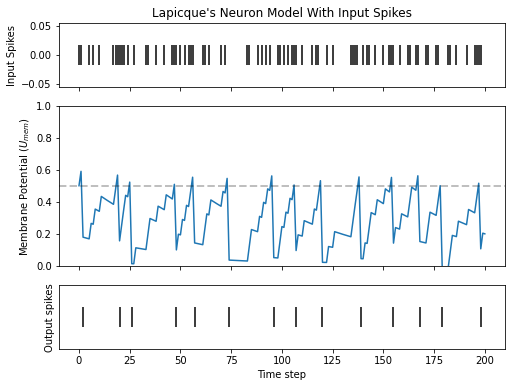

In [310]:
# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

# Plot input current
splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
ax[0].set_ylabel("Input Spikes")
ax[0].set_title("Lapicque's Neuron Model With Input Spikes")
plt.yticks([]) 

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(torch.tensor(spk_rec), ax[2], s=400, c="black", marker="|")
plt.ylabel("Output spikes")
plt.yticks([]) 

plt.show()

### 2.3.5 Lapicque: Reset Mechanisms

The final detail of the Lapicque neuron we want to explore is the sharp drop of membrane potential every time the neuron emits an output spike. This sharp drops promotes a reduction of spike generation, which supplements part of the theory on how brains are so power efficient. Biologically, this is known as the 'refractory period' where the the neuron's firing ability is momentarily suppressed. Here, we use a reset mechanism to crudely model the refractory period.

There are two ways to implement the reset mechanism:

1.  *reset by subtraction* (default) $-$ subtract the threshold from the membrane potential each time a spike is generated;
2.   *reset to zero* $-$ force the membrane potential to zero each time a spike is generated.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>

Let's instantiate another neuron model to demonstrate how to alternate between reset mechanisms. 

By default, snnTorch neuron models use `reset_mechanism = "subtract"`. This can be explicitly overridden by passing the argument `reset_mechanism =  "zero"`.

In [311]:
# Reset mechanism: zero
lif4 = snn.Lapicque(R=5, C=10, threshold=0.5, reset_mechanism="zero")

# Refresh all our hidden and output variables
mem = torch.ones(1)*0.5  # membrane potential of 0.5 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

# Create a trace of the variables of interest
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Run the simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)

  # Store recordings of output and hidden states
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

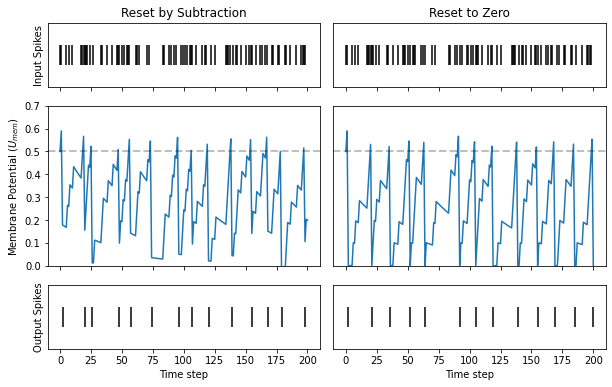

In [312]:
# Generate Plots to Compare Reset Mechanisms
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

# Reset by Subtraction: input spikes
splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
ax[0][0].set_ylabel("Input Spikes")
ax[0][0].set_title("Reset by Subtraction")
ax[0][0].set_yticks([])

# Reset by Subtraction: membrane potential 
ax[1][0].plot(mem_rec)
ax[1][0].set_ylim([0, 0.7])
ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

# Reset by Subtraction: output spikes
splt.raster(torch.tensor(spk_rec), ax[2][0], s=400, c="black", marker="|")
ax[2][0].set_yticks([])
ax[2][0].set_xlabel("Time step")
ax[2][0].set_ylabel("Output Spikes")

# Reset to Zero: input spikes
splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
ax[0][1].set_title("Reset to Zero")
ax[0][1].set_yticks([])

# Reset to Zero: membrane potential
ax[1][1].plot(mem_rec0)
ax[1][1].set_ylim([0, 0.7])
ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
ax[1][1].set_yticks([])
ax[2][1].set_xlabel("Time step")

# Reset to Zero: output spikes
splt.raster(torch.tensor(spk_rec0), ax[2][1], s=400, c="black", marker="|")
ax[2][1].set_yticks([])

plt.show()

Pay close attention to the evolution of the membrane potential, especially in the moments after it reaches the threshold. You may notice that for "Reset to Zero", the membrane potential is forced back to zero after each spike.

So which one is better? Applying `"subtract"` (the default value in `reset_mechanism`) is less lossy, because it does not ignore how much the membrane exceeds the threshold by.

On the other hand, applying a hard reset with `"zero"` promotes sparsity and potentially less power consumption when running on dedicated neuromorphic hardware. Both options are available for you to experiment with. 

## 2.4 Stein's LIF Neuron Model

The passive membrane model allows discrete current spikes to be passed directly into the neuron. In reality, a spike will result in the gradual release of neurotransmitters from the pre-synaptic neuron to the post-synaptic neuron. Stein's model, [first published in 1965](https://www.sciencedirect.com/science/article/pii/S0006349565867091), accounts for the gradual temporal dynamics of input current, and was amongst the first to introduce a reset to zero mechanism.

### 2.4.1 Stein: Synaptic Current

If a pre-synaptic neuron fires, the voltage spike is transmitted down the axon of the neuron. It triggers the vesicles to release neurotransmitters into the synaptic cleft. These activate the post-synaptic receptors, which directly influence the effective current that flows into the post-synaptic neuron. 

Shown below are two types of excitatory receptors.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_6_synaptic.png?raw=true' width="600">
</center>

The simplest model of synaptic current is an increasing current on a fast time-scale, followed by a relatively slow exponential decay. This is very similar to the membrane potential dynamics of Lapicque's model. T

Stein's neuron model combines the synaptic current dynamics with the passive membrane. It must be instantiated with two input arguments:
* $\alpha$: the decay rate of the synaptic current
* $\beta$: the decay rate of the membrane potential (as with Lapicque)

In [313]:
# Decay rate of LIF states
alpha = 0.9
beta = 0.8

# Initialize Stein neuron
lif5 = snn.Stein(alpha=alpha, beta=beta)

Using this neuron is the exact same as Lapcique's neuron, but now with the addition of synaptic current `syn` as an input and output:

**Inputs**
* `spk_in`: each element of $I_{\rm in}$ is sequentially passed as an input
* `syn`: synaptic current $I_{\rm syn}[t]$ at the present time $t$
* `mem`: membrane potential $U_{\rm mem}[t]$ at the present time $t$

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t+1]$ at the next time step ('1' if there is a spike; '0' if there is no spike)
* `syn`: synaptic current $I_{\rm syn}[t+1]$ at the next time step
* `mem`: membrane potential $U_{\rm mem}[t+1]$ at the next time step

These all need to be of type `torch.Tensor`.

Apply a periodic spiking input to see how current and membrane evolve with time:

In [314]:
# Initialize hidden states and output
syn = torch.zeros(1)  # synaptic current of 0 at t=0
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

# Periodic spiking input, spk_in = 0.2 V
spk_period = torch.cat((torch.ones(1)*0.2, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

syn_rec = [syn]
mem_rec = [mem]
spk_rec = [spk_out]

for step in range(num_steps):
  spk_out, syn, mem = lif5(spk_in[step], syn, mem)

  # Store recordings of output and hidden states
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

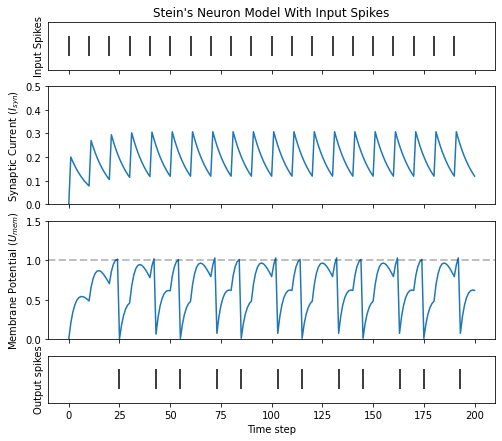

In [315]:
# Generate Plots
fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                       gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

# Plot input current
splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
ax[0].set_ylabel("Input Spikes")
ax[0].set_title("Stein's Neuron Model With Input Spikes")
ax[0].set_yticks([]) 

# Plot membrane potential
ax[1].plot(syn_rec)
ax[1].set_ylim([0, 0.5])
ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
plt.xlabel("Time step")

# Plot membrane potential
ax[2].plot(mem_rec)
ax[2].set_ylim([0, 1.5])
ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(torch.tensor(spk_rec), ax[3], s=400, c="black", marker="|")
plt.ylabel("Output spikes")
ax[3].set_yticks([]) 

plt.show()

Formally, the total synaptic current is the sum of all the contributions of all input spikes. The synaptic current is integrated by the membrane potential and generates its own output spikes:

$$I_{\rm syn} = -g_{\rm syn}(t)(U-E_{\rm syn}),$$

where $g_{\rm syn}$ is the synaptic conductance, $U$ is the instantaneous voltage applied to the input of the neuron (i.e., the input spikes), and $E_{\rm syn}$ is the reversal potential of the synapse and is set to 0 for simplicity.

$$g_{\rm syn}(t) = \sum_k \bar{g}_{syn} e^{-(t-t_k)/\tau}\Theta(t-t_k),$$

where $\bar{g}$ is a constant amplitude, $t_k$ is the timing of the incident spike, $\Theta(t)$ is the Heaviside step function. Each spike contributes a shifted exponential decay to the total conductance $g_{\rm syn}(t)$ which are all summed together.

If the math doesn't make sense, don't worry about it. A graphical intuition is usually sufficient to understand the essence of the Stein neuron model. 



<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_7_stein.png?raw=true' width="600">
</center>

Stein's model has the same optional input arguments of `reset_mechanism` and `threshold` as described for Lapicque's neuron model.

# 3. A Feedforward Spiking Neural Network

So far, we have only considered how one neuron reacts to a single input stimulus. snnTorch makes it extremely straightforward to scale this up to a deep neural network. Here, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10.

Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes. 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

We will use PyTorch to form the connections between neurons, and snnTorch is used to create the neurons.

In [316]:
import torch 
import torch.nn as nn

First, initialize all layers.

In [317]:
num_inputs = 784
num_hidden = 1000
num_outputs = 10

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Stein(alpha=alpha, beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Stein(alpha=alpha, beta=beta)

Next, initialize the hidden variables and outputs of each spiking neuron. 
As your networks increase in size, this will become a tedious process. So we can call a static method `init_stein` to take care of this. All neurons in snnTorch have their own initialization methods that follow this same syntax, e.g., `init_lapicque`:
* The first dimension is the `batch_size` which we will just set to 1
* The second dimension is the number of neurons in the layer

In [425]:
# Only use a single sample
batch_size = 1

# Initialize hidden states and outputs
spk1, syn1, mem1 = lif1.init_stein(batch_size, num_hidden)
spk2, syn2, mem2 = lif2.init_stein(batch_size, num_outputs)

# Lists to record output traces
mem2_rec = []
spk1_rec = []
spk2_rec = []

Create an input spike train to pass into the network. There are 200 time steps to simulate across 784 input neurons, so the dimensions of this input tensor must be 200 $\times$ 784:

In [426]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))*0.1)

Now it's finally time to run a full simulation. 
An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch instantiates the spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Recall that the output of a spiking neuron is $S_{\rm out}=1$ when a spike is triggered. This spike is multiplied by the weight initialized by `nn.Linear` $S_{\rm out}^{i}\times W^{i, j}$, just as the output activation of a standard artificial neuron would be in a non-spiking neural network. The weighted spike is then passed as the input to the next layer of neurons for a given time step. If there is no spike, then nothing is passed to the post-synaptic neuron.

The only difference from our simulations thus far is that we sequentially pass the output through additional layers of neurons. 

In [427]:
for step in range(num_steps):
    cur1 = fc1(spk_in[step])
    spk1, syn1, mem1 = lif1(cur1, syn1, mem1)
    cur2 = fc2(spk1)
    spk2, syn2, mem2 = lif2(cur2, syn2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert output recordings to tensors
mem2_rec = torch.stack(mem2_rec, dim=0)
spk1_rec = torch.stack(spk1_rec, dim=0)
spk2_rec = torch.stack(spk2_rec, dim=0)

At this stage, the spikes have don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But let's take a look at the raster plots just to check that the spikes are propagating to the output layer.

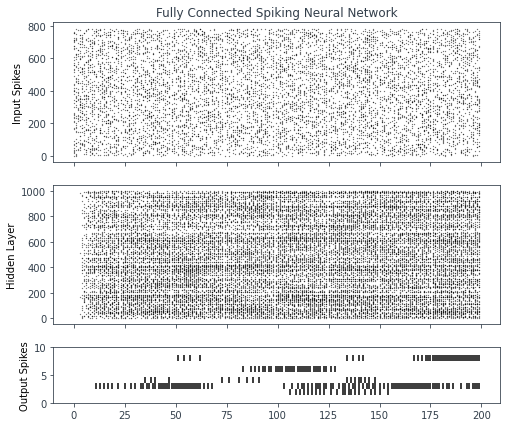

In [428]:
# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                       gridspec_kw = {'height_ratios': [1, 1, 0.4]})

# Plot input spikes
splt.raster(spk_in, ax[0], s=0.05, c="black")
ax[0].set_ylabel("Input Spikes")
ax[0].set_title("Fully Connected Spiking Neural Network")

# Plot hidden layer spikes
splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
ax[1].set_ylabel("Hidden Layer")

# Plot output spikes
splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
ax[2].set_ylabel("Output Spikes")
ax[2].set_ylim([0, 10])

plt.show()

We can also use `spikeplot.spike_count` to generate a spike counter of the output layer:

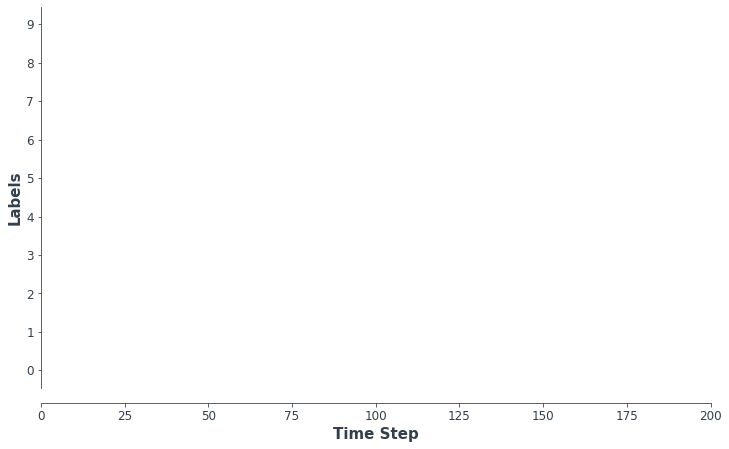

In [432]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.gif")

We can also visualize the membrane potential traces with `spikeplot.traces`. We'll plot 9 out of 10 output neurons. Compare it to the animation and raster plot above to see if you can match the traces to the neuron. 

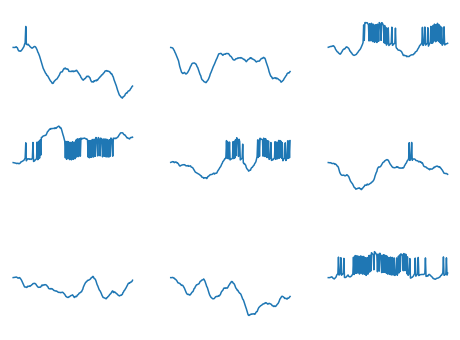

In [323]:
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))

fig = plt.gcf() 
fig.set_size_inches(8, 6)

# 4. $0^{\rm th}$-Order Spike Response Model

To finish up this tutorial, a recursive version of the $0^{\rm th}$-Order Spike Response Model (SRM) is also available, called using `snntorch.SRM0`. The neuron models thus far have all been based on the passive membrane model, using ordinary differential equations to describe their dynamics.

The SRM family of models, on the other hand, is interpreted in terms of a filter. Upon the arrival of an input spike, this spike is convolved with the filter to give the membrane potential response. The form of this filter can 
be exponential, as is the case with Lapicque's neuron, or they can be more complex such as a sum of exponentials. SRM models are appealing as they can arbitrarily add refractoriness, threshold adaptation, and any number of other features simply by embedding them into the filter. 

<left>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/exp.gif?raw=true' width="400">
</left> 

<right>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/alpha.gif?raw=true' width="400">
</right> 

Formally, this process is represented by:

$$U_{\rm mem}(t) = \sum_i w_i(\epsilon * s_i)(t)$$

where the incoming spikes $s_i$ are convolved with a spike response kernel $\epsilon( \cdot )$. The spike response is scaled by a synaptic weight, $w_i$. In the figures above, the left kernel is an exponentially decaying function and would be the equivalent of Lapicque's neuron model. On the right, the kernel is an alpha function.

In snnTorch, the SRM0 model is not directly implemented as a filter. Instead, it is recast into a recursive form such that only the previous time step of values are required to calculate the next set of values. This significantly reduces the memory overhead during learning.

The filter adopted is the alpha function on the right animation above, or equivalently a sum of two exponentials. This results in a membrane potential which peaks at some time delay $t_d$ after the input spike. This is often a desirable feature when training networks that rely on spike timing.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_9_alpha.png?raw=true' width="600">
</center> 


As the membrane potential is now determined by the sum of two exponentials, each of these exponents has their own independent decay rate. $\alpha$ defines the decay rate of the positive exponential, and $\beta$ defines the decay rate of the negative exponential. 

In [386]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif6 = snn.SRM0(alpha=alpha, beta=beta, threshold=0.5)

Using this neuron is the same as the previous neurons, but the sum of two exponential functions requires the synaptic current `syn` to be split into a `pre_syn` and `post_syn` component:

**Inputs**
* `spk_in`: each element of $I_{\rm in}$ is sequentially passed as an input
* `pre_syn`: pre-synaptic current $I_{\rm pre-syn}[t]$ at the present time $t$
* `post_syn`: post-synaptic current $I_{\rm post-syn}[t]$ at the present time $t$
* `mem`: membrane potential $U_{\rm mem}[t]$ at the present time $t$

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t+1]$ at the next time step ('1' if there is a spike; '0' if there is no spike)
* `pre_syn`: pre-synaptic current $I_{\rm pre-syn}[t+1]$ at the next time step $t$
* `post_syn`: post-synaptic current $I_{\rm post-syn}[t+1]$ at the next time step $t$
* `mem`: membrane potential $U_{\rm mem}[t+1]$ at the next time step

As with all other neuron models, these must be of type `torch.Tensor`.

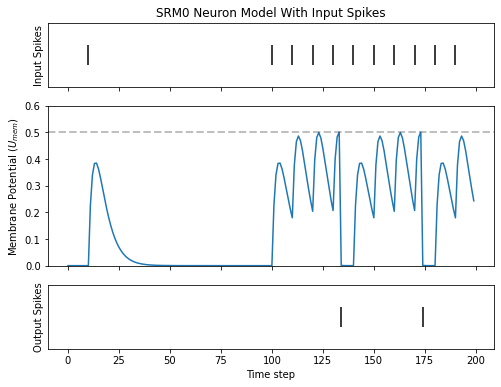

In [400]:
# input spike: initial spike, and then period spiking 
spk_in = torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89), (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * 0.85

# initialize parameters
spk_out, pre_syn, post_syn, mem = lif6.init_srm0(1, 1)
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, pre_syn, post_syn, mem = lif6(spk_in[step], pre_syn, post_syn, mem)

  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

mem_rec = torch.stack(mem_rec, dim=0).squeeze(1)
spk_rec = torch.stack(spk_rec, dim=0).squeeze(1)

# Generate Plots
fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                       gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

# Plot input current
splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
ax[0].set_ylabel("Input Spikes")
ax[0].set_title("SRM0 Neuron Model With Input Spikes")
ax[0].set_yticks([]) 

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 0.6])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
plt.xlabel("Time step")

# Plot output spike using spikeplot
splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
ax[2].set_yticks([])
ax[2].set_ylabel("Output Spikes")

plt.show()

As with the Lapicque and Stein models, the SRM0 model also has options to modify the threshold and reset mechanism.

# Conclusion

Now you should understand the basics of several LIF neuron models, how to simulate them, and how to build your own feedforward spiking neural networks.

For reference, the documentation [can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.html).

In the next tutorial, you will learn how to train these networks to classify spiking and static MNIST datasets.

## Further Reading
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Stein and SRM0 models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan